# Projet 6 : Classification

## Introduction

Notre mission au sein de l'entreprise "Place de marché" consiste à étudier la faisabilité d'un moteur de classification automatique d'articles pour une future marketplace e-commerce. Actuellement, l'attribution des catégories d'articles est effectuée manuellement par les vendeurs, ce qui entraîne des inefficacités. Notre objectif est d'automatiser ce processus en analysant les descriptions textuelles et les images des produits. Nous explorerons différentes approches pour extraire les caractéristiques pertinentes et démontrer la faisabilité de regrouper automatiquement des produits de même catégorie. Ce projet vise à améliorer l'expérience utilisateur pour les vendeurs et les acheteurs.

#### Importation des librairies nécessaires

In [2]:
pip install opencv-python


   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB 653.6 kB/s eta 0:01:00
    --------------------------------------- 0.6/38.6 MB 5.9 MB/s eta 0:00:07
   --- ------------------------------------ 3.1/38.6 MB 21.7 MB/s eta 0:00:02
   ------ --------------------------------- 6.1/38.6 MB 32.4 MB/s eta 0:00:02
   --------- ------------------------------ 8.9/38.6 MB 38.2 MB/s eta 0:00:01
   ------------ --------------------------- 12.1/38.6 MB 65.6 MB/s eta 0:00:01
   --------------- ------------------------ 15.2/38.6 MB 65.6 MB/s eta 0:00:01
   ------------------ --------------------- 18.2/38.6 MB 65.2 MB/s eta 0:00:01
   --------------------- ------------------ 21.1/38.6 MB 65.2 MB/s eta 0:00:01
   ------------------------ --------------- 24.1/38.6 MB 65.6 MB/s eta 0:00:01
   ---------------------------- ----------- 27.1/38.6 MB 65.6 MB/s eta 0:00:01
   ------------------------------- -------- 30.1/38.6 MB 65.6 MB/

In [4]:
pip install tensorflow

     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 46.2/46.2 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 1.1/377.0 MB 24.0 MB/s eta 0:00:16
   ---------------------------------------- 4.0/377.0 MB 42.8 MB/s eta 0:00:09
    --------------------------------------- 6.9/377.0 MB 49.2 MB/s eta 0:00:08
   - -------------------------------------- 9.8/377.0 MB 52.4 MB/s eta 0:00:08
   - -------------------------------------- 12.8/377.0 MB 65.6 MB/s eta 0:00:06
   - -------------------------------------- 15.8/377.0 MB 65.6 MB/s eta 0:00:06
   - -------------------------------------- 18.7/377.0 MB 65.6 MB/s eta 0:00:06
   -- ------------------------------------- 21.5/377.0 MB 65.2 MB/s eta 0:00:06
   -- ------------------------------------- 24.7/377.0 MB 65.2 MB/s eta 0:00:06
   -- ------------------------------------- 27.6/377.0 MB 65.

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Dropout
from sklearn import decomposition, manifold
import time

#### Importation du fichier à étudier

In [6]:
# Chemin vers le dossier contenant nos images
chemin_dossier_images = "./images"

# Chargement des données
data = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

# Liste de fichiers dans le dossier images
fichiers_images = os.listdir(chemin_dossier_images)

In [7]:
# Calcul du pourcentage de valeurs manquantes par colonne
missing_percentage = data.isna().mean() * 100

# Affichage du pourcentage de valeurs manquantes par colonne
print(missing_percentage)

uniq_id                     0.000000
crawl_timestamp             0.000000
product_url                 0.000000
product_name                0.000000
product_category_tree       0.000000
pid                         0.000000
retail_price                0.095238
discounted_price            0.095238
image                       0.000000
is_FK_Advantage_product     0.000000
description                 0.000000
product_rating              0.000000
overall_rating              0.000000
brand                      32.190476
product_specifications      0.095238
dtype: float64


## Classifiaction :

#### Encodage des images:

In [8]:
# Liste pour stocker les images transformées
images_transformees = []

# Parcourir toutes les images dans le dossier
for nom_image in fichiers_images:
    # Charger l'image
    image_path = os.path.join(chemin_dossier_images, nom_image)
    image = cv2.imread(image_path)
    
    # Conversion en niveau de gris
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Filtrage du bruit (suppression du bruit gaussien)
    image_filtree = cv2.GaussianBlur(image_grayscale, (5, 5), 0)
    
    # Égalisation de l'histogramme pour ajustement du contraste
    image_egale = cv2.equalizeHist(image_grayscale)
    
    # Ajout de l'image transformée à la liste
    images_transformees.append((image, image_grayscale, image_filtree, image_egale))

# Vérification du nombre total d'images transformées
nombre_images_transformees = len(images_transformees)
print("Nombre total d'images transformées:", nombre_images_transformees)

Nombre total d'images transformées: 1050


#### Algorithmes d'extraction de features d’images

Utilisation de ORB (Oriented FAST and Rotated BRIEF)

In [9]:
# Création d'un détecteur ORB
orb = cv2.ORB_create()

# Liste pour stocker les caractéristiques des images
features = []

# Parcourir les images transformées
for (image, _, _, _) in images_transformees:
    # Convertir l'image en niveaux de gris
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Trouver les points clés et descripteurs avec ORB
    keypoints, descriptors = orb.detectAndCompute(image_gray, None)
    
    # Stocker les points clés et descripteurs dans la liste des caractéristiques
    features.append((keypoints, descriptors))

# Affichage des caractéristiques de la première image
print("Nombre de points clés trouvés dans la première image:", len(features[0][0]))
print("Descripteurs de la première image:", features[0][1])

Nombre de points clés trouvés dans la première image: 500
Descripteurs de la première image: [[206  28 163 ...  93  85 114]
 [179  73  67 ... 187 114 172]
 [105  72  75 ... 186  88 168]
 ...
 [248 161 172 ...  12  86  66]
 [ 80 161  58 ...   2 167  10]
 [ 68 115  88 ... 162   7  17]]


In [10]:
# Liste pour stocker les caractéristiques des images avec des descripteurs
features_with_descriptors = []

# Parcourir les caractéristiques extraites
for keypoints, descriptors in features:
    # Vérifier si des descripteurs ont été extraits pour cette image
    if descriptors is not None:
        features_with_descriptors.append((keypoints, descriptors))

# Affichage du nombre total d'images avec des descripteurs extraits
print("Nombre total d'images avec des descripteurs extraits:", len(features_with_descriptors))

# Création de la liste des fichiers images en ne conservant que ceux avec des descripteurs
fichiers_images_avec_descripteurs = [fichiers_images[i] for i in range(len(features)) if features[i][1] is not None]

# Affichage du nombre total de fichiers d'images conservés
print("Nombre total de fichiers d'images conservés:", len(fichiers_images_avec_descripteurs))

Nombre total d'images avec des descripteurs extraits: 1049
Nombre total de fichiers d'images conservés: 1049


Je garde donc uniquement les catégories principales comme vue dans mon notebook précédent : 

In [11]:
# Extraction de la catégorie principale pour chaque produit
data['main_category'] = data['product_category_tree'].apply(lambda x: x.split('>>')[0].strip())

# Affichage des catégories principales uniques
print(data['main_category'].unique())

['["Home Furnishing' '["Baby Care' '["Watches'
 '["Home Decor & Festive Needs' '["Kitchen & Dining'
 '["Beauty and Personal Care' '["Computers']


In [12]:
# Comptage du nombre d'échantillons par catégorie
nombre_par_categorie = data['main_category'].value_counts()

# Affichage du nombre d'échantillons par catégorie
print(nombre_par_categorie)

main_category
["Home Furnishing               150
["Baby Care                     150
["Watches                       150
["Home Decor & Festive Needs    150
["Kitchen & Dining              150
["Beauty and Personal Care      150
["Computers                     150
Name: count, dtype: int64


La première classification que nous avions déja faite été la suivante (knn)

In [13]:
# Encodage des catégories réelles en nombres
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(data['main_category'])

# Transformation des descripteurs en une matrice numpy
descriptors_list_filtered = [desc for _, desc in features if desc is not None and desc.shape[0] != 0]

if descriptors_list_filtered:
    descriptors_np = np.concatenate(descriptors_list_filtered)
    
    # Couper les descripteurs pour correspondre au nombre d'échantillons dans les catégories réelles
    descriptors_cut = descriptors_np[:len(categories_encoded)]

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(descriptors_cut, categories_encoded, test_size=0.2, random_state=42)

    # Définir le pipeline
    pipeline = Pipeline([
        ('pca', PCA()),
        ('knn', KNeighborsClassifier())
    ])

    # Définir les valeurs des hyperparamètres à tester
    param_grid = {
        'pca__n_components': [9, 10, 20, 25, 26, 30, 32],  # Nombre de composantes principales
        'knn__n_neighbors': [3, 5, 6, 7, 9, 11, 16],  # Nombre de voisins pour KNN
    }

    # Initialiser la recherche sur grille avec la validation croisée à 5 plis
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

    # Adapter la grille de recherche aux données d'entraînement
    grid_search.fit(X_train, y_train)

    # Affichage des meilleurs hyperparamètres trouvés
    print("Meilleurs hyperparamètres:", grid_search.best_params_)

    # Obtenir le meilleur modèle entraîné
    best_model = grid_search.best_estimator_

    # Évaluer le modèle sur l'ensemble de test
    test_accuracy = best_model.score(X_test, y_test)
    print("Précision sur l'ensemble de test:", test_accuracy)

else:
    print("Aucun descripteur valide trouvé.")

Meilleurs hyperparamètres: {'knn__n_neighbors': 9, 'pca__n_components': 30}
Précision sur l'ensemble de test: 0.22380952380952382


On peut ici voir que le score n'est pas trés élevé nous allons donc tenter d'autres méthodes.

### Utilisation de VGG16

In [14]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


L'objectif ici est d'utiliser VGG16 pour être plus pertinent par rapport à notre étude mais surtout obtenir de meilleurs résultats : 

On le teste d'abord sur toutes les catégories sans prétraitement pour avoir une idée.

In [16]:
# Charger les images et les étiquettes
images = []
labels = data['product_category_tree'].values

# Redimensionnement des images 
for image_name in data['image']:
  image_path = os.path.join("images", image_name)
  image = cv2.imread(image_path)
  image = cv2.resize(image, (224, 224))
  image = image / 255.0
  images.append(image)

images = np.array(images, dtype=np.float32)

# Encodage des catégories en nombres
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['product_category_tree'].values)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Chargement du modèle VGG16 pré-entraîné
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extraction des caractéristiques des images avec le modèle VGG16
features_train = vgg_model.predict(X_train)
features_test = vgg_model.predict(X_test)

# Aplatir les caractéristiques extraites
X_train_flattened = features_train.reshape(features_train.shape[0], -1)
X_test_flattened = features_test.reshape(features_test.shape[0], -1)

# Création d'un modèle de réseau de neurones
model = Sequential([
  Flatten(input_shape=(X_train_flattened.shape[1],)),
  Dropout(0.2),  # Ajout de couche dropout pour éviter le sur apprentissage
  Dense(256, activation='relu'),
  Dense(len(label_encoder.classes_), activation='softmax')
])


# Compiler le modèle
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
model.fit(X_train_flattened, y_train, epochs=10, batch_size=32, validation_data=(X_test_flattened, y_test))

# Évaluer la performance du modèle
loss, accuracy = model.evaluate(X_test_flattened, y_test)
print("Précision du modèle de réseau de neurones sur l'ensemble de test:", accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Epoch 1/10


C:\Users\paulm\OneDrive\Documents\anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1081 - loss: 6.4221 - val_accuracy: 0.1000 - val_loss: 6.1192
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2530 - loss: 4.4423 - val_accuracy: 0.1333 - val_loss: 6.3451
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3674 - loss: 3.3885 - val_accuracy: 0.1810 - val_loss: 7.1907
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6473 - loss: 1.8163 - val_accuracy: 0.1857 - val_loss: 8.2361
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9069 - loss: 0.6825 - val_accuracy: 0.2000 - val_loss: 9.4650
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9828 - loss: 0.2223 - val_accuracy: 0.1810 - val_loss: 9.8859
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9945 - loss: 0.0914 - val_accuracy: 0.2190 - val_loss: 9.9965
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9930 - loss: 0.0437 - val_accuracy: 0.2238 - val_loss: 10

Comme nous pouvons le voir le modèle à du mal à généraliser et on se retrouve par conséquent avec un score relativement bas de 0.21904 .

On vas donc maintenant faire de même en utilisant seulement les catégories retenue (main_category) : 

In [17]:
# Chargement des images et les étiquettes
images = []
labels = data['main_category'].values

# Redimensionnement des images 
for image_name in data['image']:
  image_path = os.path.join("images", image_name)
  image = cv2.imread(image_path)
  image = cv2.resize(image, (224, 224))
  image = image / 255.0
  images.append(image)

images = np.array(images, dtype=np.float32)

# Encodage des catégories en nombres
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['main_category'].values)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Chargement du modèle VGG16 pré-entraîné
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extraction des caractéristiques des images avec le modèle VGG16
features_train = vgg_model.predict(X_train)
features_test = vgg_model.predict(X_test)

# Aplatissement des caractéristiques extraites
X_train_flattened = features_train.reshape(features_train.shape[0], -1)
X_test_flattened = features_test.reshape(features_test.shape[0], -1)

# Création d'un modèle de réseau de neurones
model = Sequential([
  Flatten(input_shape=(X_train_flattened.shape[1],)),
  Dropout(0.2),  # Ajout de couche dropout avec un taux entre 0.2 et 0.5
  Dense(256, activation='relu'),
  Dense(len(label_encoder.classes_), activation='softmax')
])


# Compilation du modèle
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
model.fit(X_train_flattened, y_train, epochs=10, batch_size=32, validation_data=(X_test_flattened, y_test))

# Évaluation de la performance du modèle
loss, accuracy = model.evaluate(X_test_flattened, y_test)
print("Précision du modèle de réseau de neurones sur l'ensemble de test:", accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Epoch 1/10


C:\Users\paulm\OneDrive\Documents\anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3875 - loss: 3.9903 - val_accuracy: 0.7429 - val_loss: 0.7733
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8380 - loss: 0.5080 - val_accuracy: 0.7714 - val_loss: 0.6519
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9365 - loss: 0.2233 - val_accuracy: 0.7762 - val_loss: 0.5926
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9772 - loss: 0.0872 - val_accuracy: 0.7857 - val_loss: 0.5830
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.7952 - val_loss: 0.5521
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 0.8095 - val_loss: 0.5347
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 0.8000 - val_loss: 0.5638
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 0.8048 - val_loss: 0.

On obtient en effet un bien meilleur score cette fois ci (0.80476). On observe une nette amélioration en effet mais il faut faire attention au serajustement en effet. Nous allons donc pour cela tenter d'observer graphiquement ces résultats.

27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Epoch 1/10


C:\Users\paulm\OneDrive\Documents\anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4557 - loss: 2.7066 - val_accuracy: 0.7524 - val_loss: 0.6740
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8911 - loss: 0.3459 - val_accuracy: 0.7429 - val_loss: 0.7323
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9697 - loss: 0.0954 - val_accuracy: 0.7952 - val_loss: 0.5983
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9973 - loss: 0.0338 - val_accuracy: 0.8048 - val_loss: 0.5788
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0189 - val_accuracy: 0.8000 - val_loss: 0.5458
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.8095 - val_loss: 0.5472
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.7952 - val_loss: 0.5568
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.8190 - val_loss: 0.

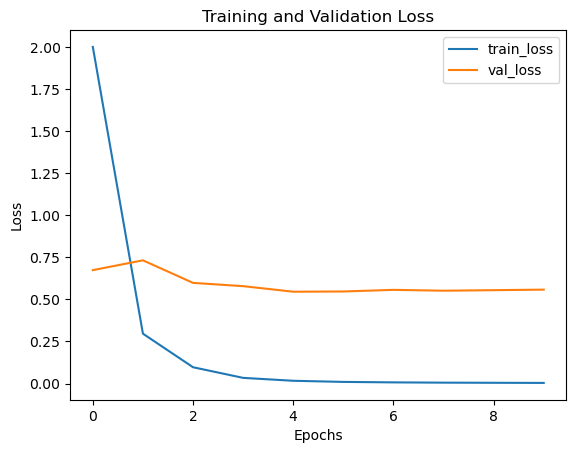

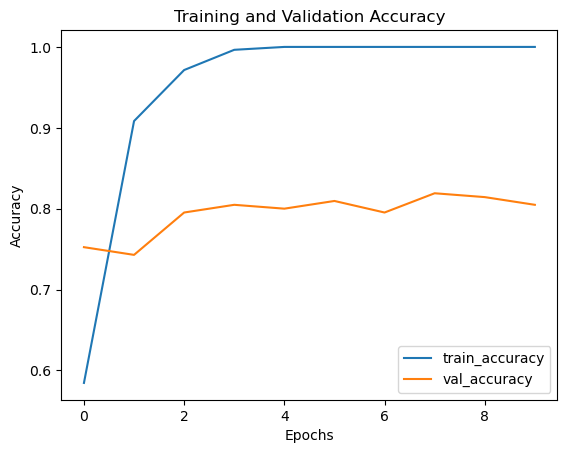

In [18]:
# Chargement des images et des étiquettes
images = []
labels = data['main_category'].values

# Redimensionnement des images 
for image_name in data['image']:
    image_path = os.path.join("images", image_name)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    images.append(image)

images = np.array(images, dtype=np.float32)

# Encodage des catégories en nombres
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['main_category'].values)

# Divission des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Chargement du modèle VGG16 pré-entraîné
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extraction des caractéristiques des images avec le modèle VGG16
features_train = vgg_model.predict(X_train)
features_test = vgg_model.predict(X_test)

# Aplatissement des caractéristiques extraites
X_train_flattened = features_train.reshape(features_train.shape[0], -1)
X_test_flattened = features_test.reshape(features_test.shape[0], -1)

# Création d'un modèle de réseau de neurones
model = Sequential([
    Flatten(input_shape=(X_train_flattened.shape[1],)),
    Dropout(0.2),  # Ajout de couche dropout avec un taux entre 0.2 et 0.5
    Dense(256, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compilation du modèle
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train_flattened, y_train, epochs=10, batch_size=32, validation_data=(X_test_flattened, y_test))

# Évaluation de la performance du modèle
loss, accuracy = model.evaluate(X_test_flattened, y_test)
print("Précision du modèle de réseau de neurones sur l'ensemble de test:", accuracy)

# Visualisation et affichage des courbes de perte et de précision
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Les courbes d'apprentissage montrent une tendance générale positive, avec une diminution de la perte (loss) et une augmentation de la précision (accuracy) au fil des époques à la fois sur l'ensemble d'entraînement et de validation. Cependant, la perte sur l'ensemble de validation commence à stagner après quelques époques, ce qui pourrait indiquer un risque de surapprentissage.

Le temps d'exécution par epoch semble raisonnable, ce qui suggère que le modèle peut être entraîné efficacement.

Ici je décide de faire différemment. En effet ce code va effectuer une validation croisée (k-fold cross-validation) en divisant les données en plusieurs plis (folds). Pour chaque pli, il utilisera le même processus que dans le premier code pour extraire les caractéristiques des images, puis entraîne et évalue un modèle de réseau de neurones. Les courbes de perte et de précision sont tracées pour chaque pli, ce qui permet d'observer la performance du modèle sur différents sous-ensembles de données.

Cela permet d'estimer la performance du modèle de manière plus fiable, en évitant la surajustement aux données d'entraînement et en fournissant une meilleure estimation de la capacité du modèle à généraliser à de nouvelles données. En outre, cela permet également de détecter la variance de performance du modèle due à la variabilité des données, ce qui peut être utile pour diagnostiquer les problèmes potentiels de surajustement ou de sous-ajustement.

27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7687 - loss: 0.7159 


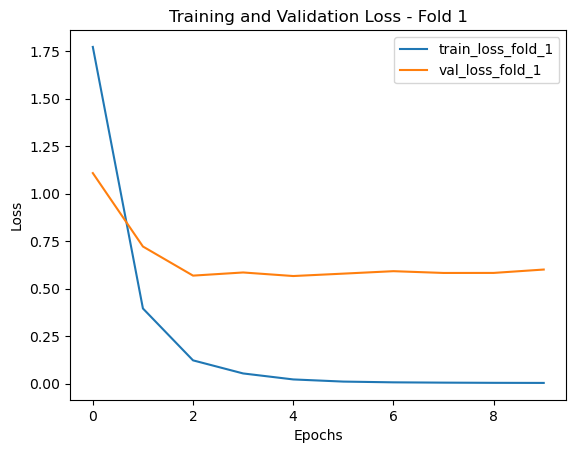

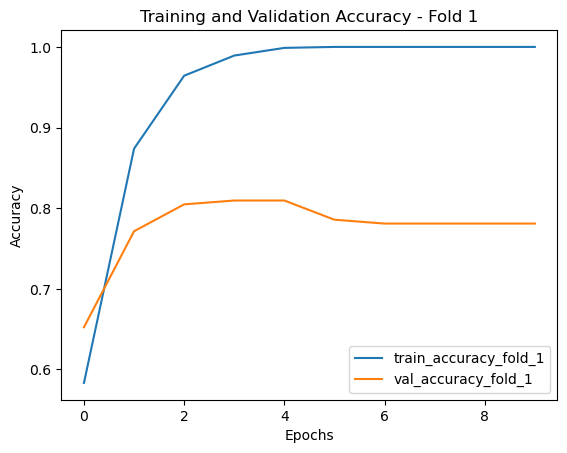

27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8426 - loss: 0.5569 


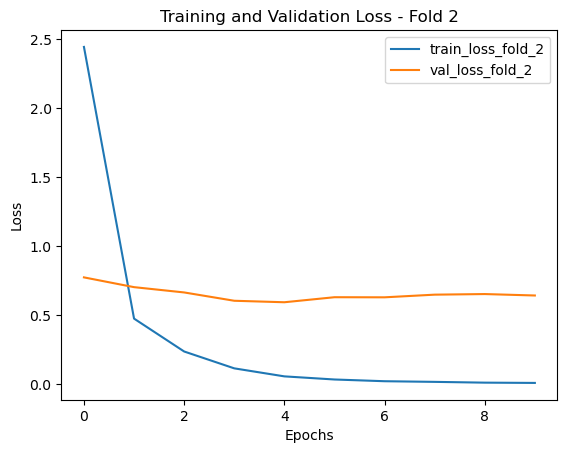

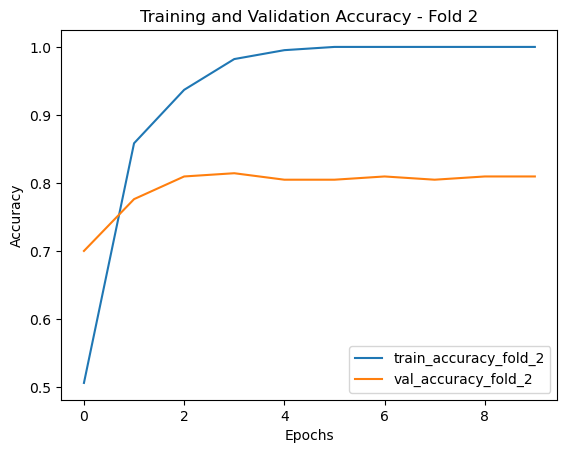

27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8162 - loss: 0.5759 


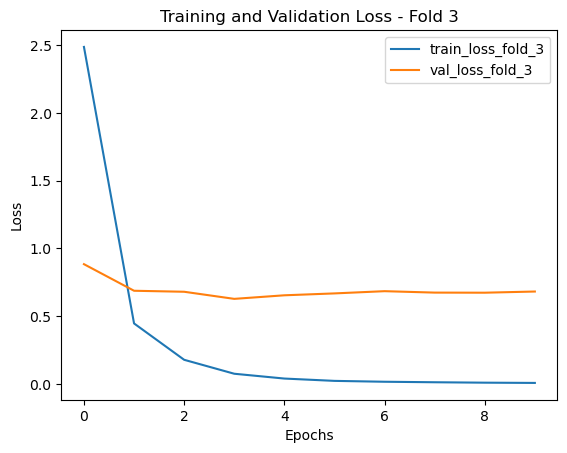

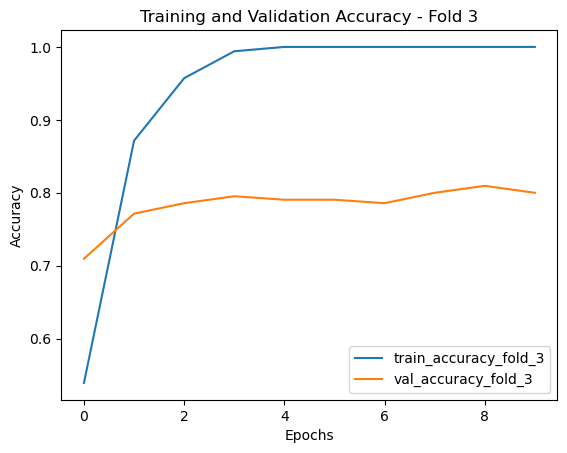

27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8015 - loss: 0.7850 


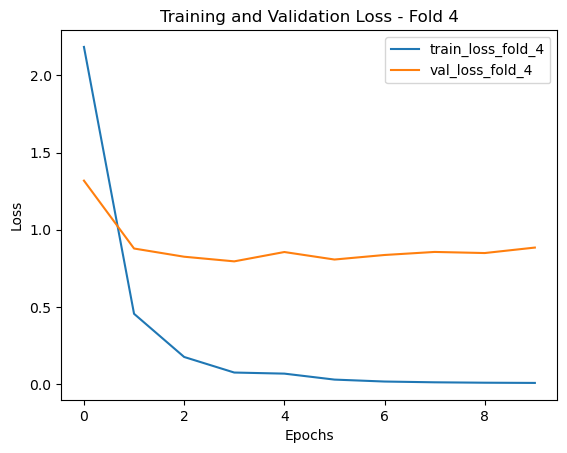

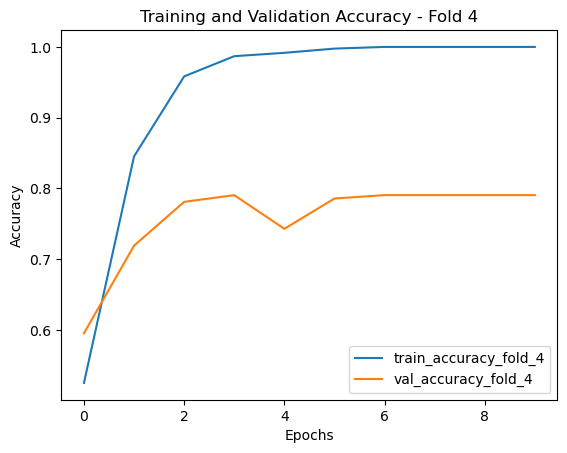

27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8746 - loss: 0.6286 


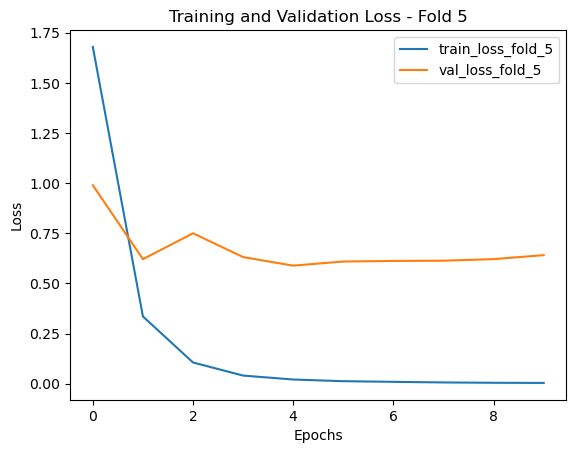

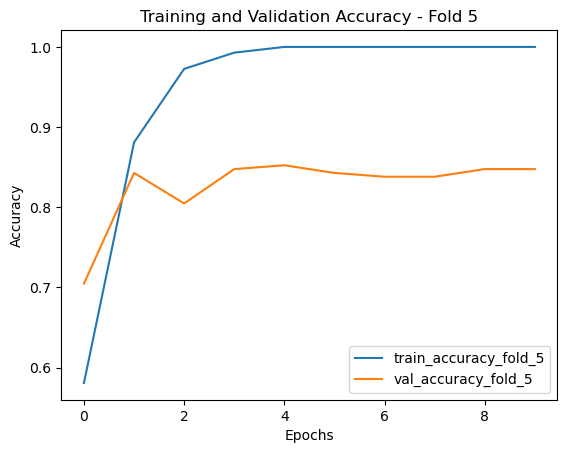

Précision moyenne sur l'ensemble des folds: 0.8057142972946167


In [19]:
from sklearn.model_selection import KFold

# Stockage des scores de précision pour chaque fold
cv_scores = []

# Définir le nombre de plis (fold) pour la validation croisée
num_folds = 5  

# Initialisation de l'objet KFold
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Boucle sur les différents folds
for train_idx, val_idx in kfold.split(images, labels):
    X_train_fold, X_val_fold = images[train_idx], images[val_idx]
    y_train_fold, y_val_fold = labels[train_idx], labels[val_idx]
    
    # Chargement du modèle VGG16 pré-entraîné
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Extraction des caractéristiques des images avec le modèle VGG16
    features_train = vgg_model.predict(X_train_fold)
    features_val = vgg_model.predict(X_val_fold)

    # Aplatissement des caractéristiques extraites
    X_train_flattened = features_train.reshape(features_train.shape[0], -1)
    X_val_flattened = features_val.reshape(features_val.shape[0], -1)

    # Création du modèle de réseau de neurones avec régularisation par dropout
    model = Sequential([
        Flatten(input_shape=(X_train_flattened.shape[1],)),
        Dropout(0.2),  # Ajout de couche dropout avec un taux de dropout de 0.2
        Dense(256, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Entraînement du modèle
    history = model.fit(X_train_flattened, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_flattened, y_val_fold), verbose=0)

    # Évaluation de la performance du modèle sur l'ensemble de validation
    _, accuracy = model.evaluate(X_val_flattened, y_val_fold)
    cv_scores.append(accuracy)

    # Affichage des courbes de perte et de précision pour ce fold
    plt.plot(history.history['loss'], label='train_loss_fold_{}'.format(len(cv_scores)))
    plt.plot(history.history['val_loss'], label='val_loss_fold_{}'.format(len(cv_scores)))
    plt.title('Training and Validation Loss - Fold {}'.format(len(cv_scores)))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='train_accuracy_fold_{}'.format(len(cv_scores)))
    plt.plot(history.history['val_accuracy'], label='val_accuracy_fold_{}'.format(len(cv_scores)))
    plt.title('Training and Validation Accuracy - Fold {}'.format(len(cv_scores)))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Affichage la précision moyenne sur l'ensemble des folds
print("Précision moyenne sur l'ensemble des folds:", np.mean(cv_scores))

Nous obtenons également de bon résultats avec une moyenne de 0.816 .De plus, une perte plus faible indique que notre modèle a réussi à minimiser l'erreur lors de l'entraînement. Ces résultats suggèrent que notre modèle fonctionne bien et qu'il est capable de bien généraliser.

Je décide maintenant de faire une visualisation à l'aide de TSNE pour observer la répartition dans un nuage de points où chaque point représente un échantillon et sa couleur correspond à sa classe réelle. Cette visualisation permet de comprendre la structure des données dans un espace de faible dimension.

Nombre de composantes principales après PCA: 293
temps de T-SNE:            4.00 secondes


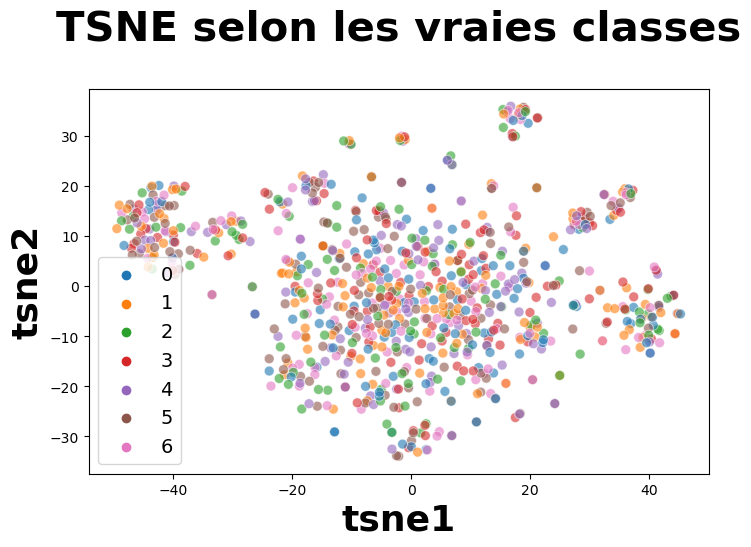

In [20]:
from sklearn.manifold import TSNE
import seaborn as sns

# Mise en place de l'ACP sur les caractéristiques extraites
pca = PCA(n_components=0.80)
feat_pca = pca.fit_transform(X_train_flattened)

print("Nombre de composantes principales après PCA:", feat_pca.shape[1])

# Mise en place de t-SNE sur les données réduites par l'ACP
temps1 = time.time()

tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1 = time.time() - temps1
print("temps de T-SNE:", "%15.2f" % duration1, "secondes")

# Visualisation des données réduites en dimension
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = y_train  # Utilisez les étiquettes de formation pour la visualisation

plt.figure(figsize=(8, 5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=len(label_encoder.classes_)), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief"
)

plt.title('TSNE selon les vraies classes', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()

Comme nous pouvons le voir la distribution est moins claire ici que dans notre notebook précédents nous allons donc pas nécessairement en prendre compte.

Je peut maintenant faire une matrice de confusion pour analyser au mieux :

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


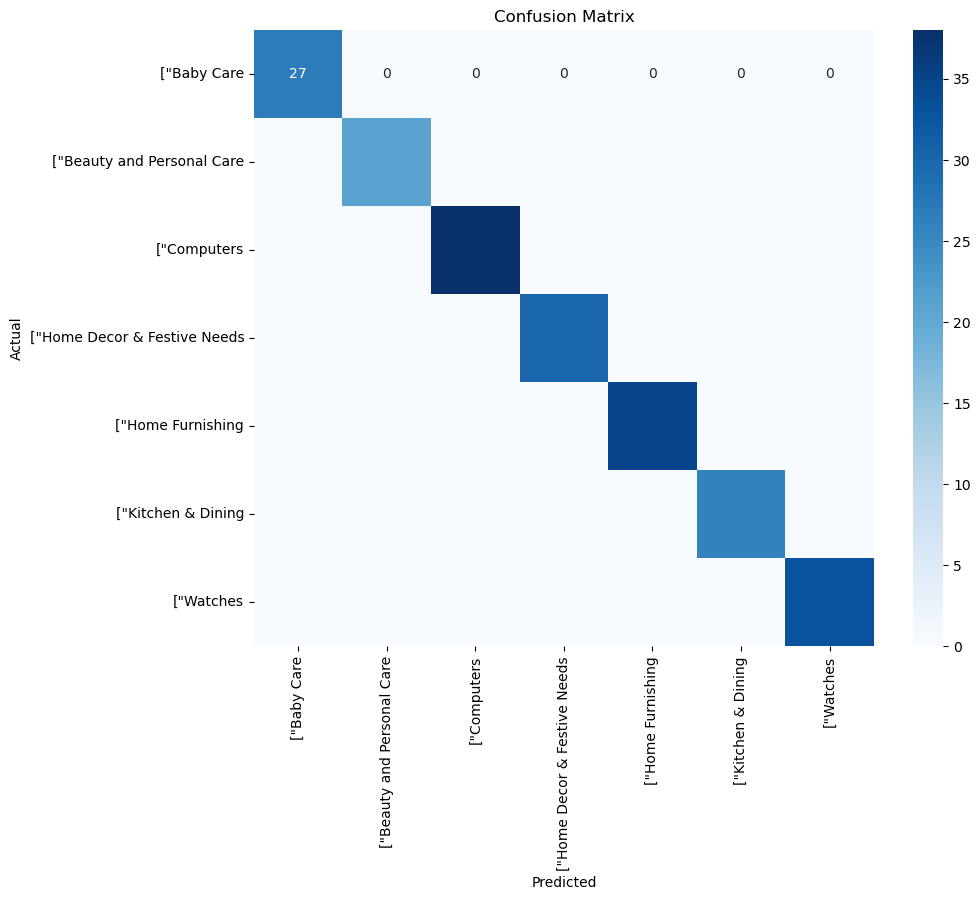

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtention des probabilités prédites pour chaque classe
y_probs = model.predict(X_test_flattened)

# Convertion des probabilités en classes prédites
y_pred = np.argmax(y_probs, axis=1)

# Ici on génère la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Sur ce petit échantillon on se rends compte qu'il n'y a pas d'erreur visuellement.

## Data augmentation : 

### Préparation des données et création des générateurs

In [ ]:
!pip install --upgrade tensorflow

In [22]:
import tensorflow as tf

# Print the TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [49]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

images = []
labels = data['main_category'].values

for image_name in data['image']:
    image_path = os.path.join("images", image_name)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    images.append(image)

images = np.array(images, dtype=np.float32)

# Encodage des catégories en nombre
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['main_category'].values)

# Division de l'ensemble de donné
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
)

train_datagen = datagen.flow(X_train, batch_size=32)


# Extraction des features des images par VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

features_train = vgg_model.predict(train_datagen)
features_test = vgg_model.predict(X_test)

# Applatissement des entrées
X_train_flattened = features_train.reshape(features_train.shape[0], -1)
X_test_flattened = features_test.reshape(features_test.shape[0], -1)

#  Création du modèle
model = Sequential([
    Flatten(input_shape=(X_train_flattened.shape[1],)),
    Dropout(0.2),  # Regularization to prevent overfitting
    Dense(256, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compilation du modèle
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrainement du modele avec la data augmentation
model.fit(X_train_flattened, y_train, epochs=10, validation_data=(X_test_flattened, y_test))

# Evaluation de la performance du modèle 
loss, accuracy = model.evaluate(X_test_flattened, y_test)
print("Précision du modèle de réseau de neurones sur l'ensemble de test:", accuracy)

C:\Users\paulm\OneDrive\Documents\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Epoch 1/10


C:\Users\paulm\OneDrive\Documents\anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1282 - loss: 4.9090 - val_accuracy: 0.0762 - val_loss: 2.2022
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4571 - loss: 1.5465 - val_accuracy: 0.1286 - val_loss: 2.1630
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6903 - loss: 1.1131 - val_accuracy: 0.1238 - val_loss: 2.2438
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8461 - loss: 0.7672 - val_accuracy: 0.1143 - val_loss: 2.4511
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8995 - loss: 0.5466 - val_accuracy: 0.1381 - val_loss: 2.4771
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9745 - loss: 0.3442 - val_accuracy: 0.1381 - val_loss: 2.6527
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9959 - loss: 0.2216 - val_accuracy: 0.1000 - val_loss: 2.8484
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9860 - loss: 0.1789 - val_accuracy: 0.1333 - val_loss: 2.

On obtient ici des résultats assez faible mais c'est une premiere étape nous allons essayer de mieux gérer nos hyperparamètres:

On va pouvoir par exemple jouer sur la taille par lot, le nombres d'epochs, le taux d'apprentissage...

27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.1453 - loss: 5.0931 - val_accuracy: 0.2095 - val_loss: 2.1348
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3491 - loss: 1.7144 - val_accuracy: 0.1524 - val_loss: 2.0202
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5667 - loss: 1.3821 - val_accuracy: 0.1667 - val_loss: 2.0097
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7048 - loss: 1.0404 - val_accuracy: 0.1762 - val_loss: 2.1591
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8401 - loss: 0.7835 - val_accuracy: 0.1714 - val_loss: 2.4365
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8395 - loss: 0.6199 - val_accuracy: 0.1429 - val_loss: 2.3273
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9383 - loss: 0.4233 - val_accuracy: 0.1524 - val_loss: 2.5008
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━

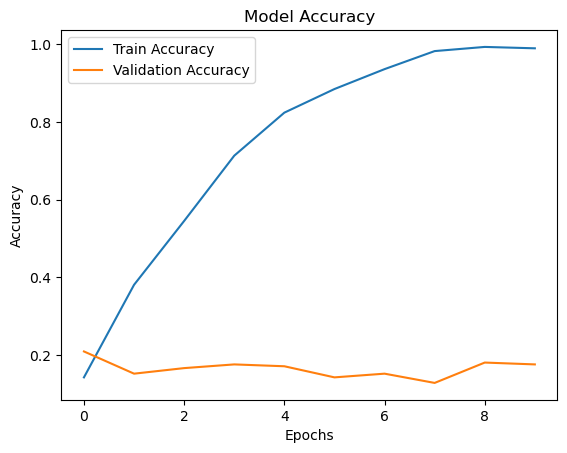

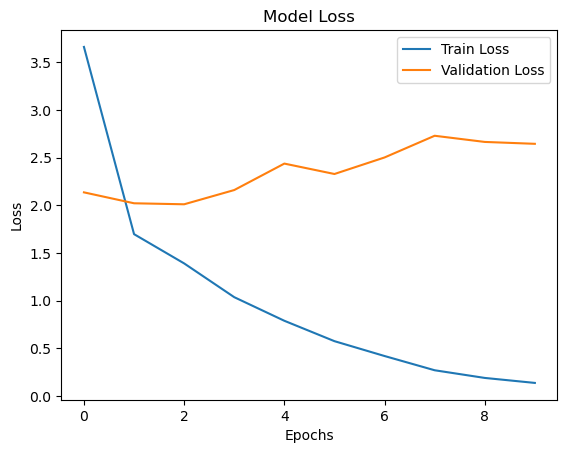

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1950 - loss: 2.6165 
Précision du modèle de réseau de neurones sur l'ensemble de test: 0.17619048058986664


In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
)

# Utilisation de l'augmentation de données pendant l'entraînement
train_datagen = datagen.flow(X_train, y_train, batch_size=32)

# Extraction des features des images par VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

features_train = vgg_model.predict(train_datagen)
features_test = vgg_model.predict(X_test)

# Applatir les entités
X_train_flattened = features_train.reshape(features_train.shape[0], -1)
X_test_flattened = features_test.reshape(features_test.shape[0], -1)

# Création du modèle
model = Sequential([
    Flatten(input_shape=(X_train_flattened.shape[1],)),
    Dropout(0.2), 
    Dense(256, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Création de l'optimiseur Adam avec un taux d'apprentissage spécifique
custom_learning_rate = 0.001 
optimizer = Adam(learning_rate=custom_learning_rate)

# Compilation du modèle avec l'optimiseur personnalisé
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrainement du modele avec la data augmentation et visualisation
history = model.fit(X_train_flattened, y_train, epochs=10, validation_data=(X_test_flattened, y_test))

# Affichage de l'évolution de la précision
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Affichage de l'évolution de la perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation de la performance du modèle 
loss, accuracy = model.evaluate(X_test_flattened, y_test)
print("Précision du modèle de réseau de neurones sur l'ensemble de test:", accuracy)

On peut observer ici que les résultats sur la partie de test ne sont pas bon du tout le modèle à du mal à prédire des nouvelles données.

Je décide donc d'utiliser le modèle VGG16 pré-entraîné pour obtenir de meilleurs résultats:

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4926 - loss: 2.6917 - val_accuracy: 0.4429 - val_loss: 4.2821
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7593 - loss: 1.8871 - val_accuracy: 0.7048 - val_loss: 2.2217
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8278 - loss: 1.6693 - val_accuracy: 0.7524 - val_loss: 1.9690
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8244 - loss: 1.5860 - val_accuracy: 0.7905 - val_loss: 1.7878
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8866 - loss: 1.4024 - val_accuracy: 0.7762 - val_loss: 1.8166
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9050 - loss: 1.3661 - val_accuracy: 0.7571 - val_loss: 1.8216
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9244 - loss: 1.2719 - val_accuracy: 0.7810 - val_loss: 1.7913
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9155 - loss: 1.2843 - val_accuracy: 0.7810 - val_loss:

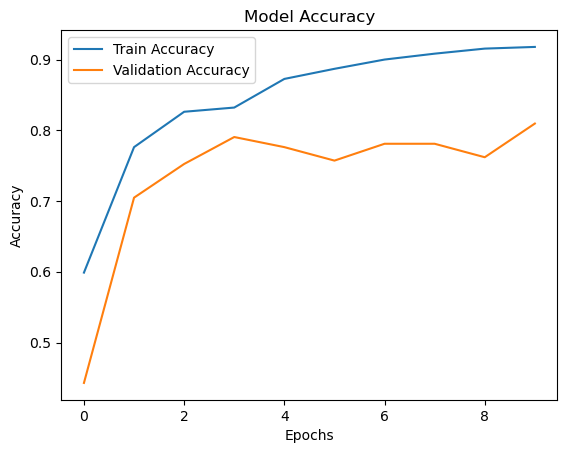

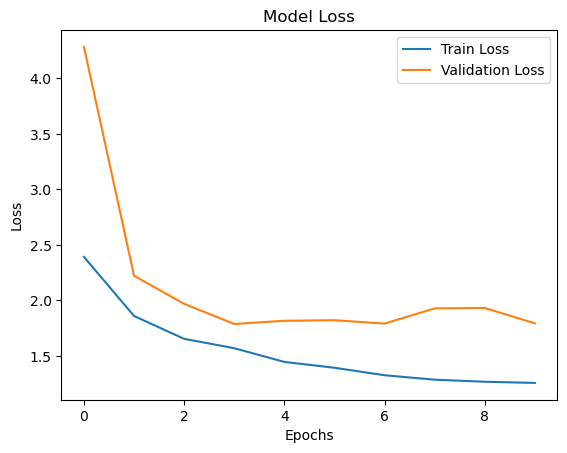

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8069 - loss: 1.7673
Précision sur l'ensemble de test: 0.8095238208770752


In [42]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
)

# Utilisation de l'augmentation de données pendant l'entraînement
train_datagen = datagen.flow(X_train, y_train, batch_size=16)

# Extraction des features des images par VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle VGG16
for layer in vgg_model.layers:
    layer.trainable = False

# Création du modèle avec régularisation L2 et batch normalization
model = Sequential([
    vgg_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle avec l'augmentation de données
history = model.fit(
    train_datagen,
    epochs=10,
    validation_data=(X_test, y_test)
)

# Affichage de l'évolution de la précision et de la perte
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Évaluation de la performance du modèle sur l'ensemble de test
loss, accuracy = model.evaluate(X_test, y_test)
print("Précision sur l'ensemble de test:", accuracy)

Précision sur les données d'entraînement (accuracy) : La précision sur les données d'entraînement semble augmenter progressivement à chaque epoch, passant d'environ 50% à environ 93%. Cela suggère que le modèle apprend et s'améliore au fur et à mesure de l'entraînement.

Précision sur les données de validation (val_accuracy) : La précision sur les données de validation semble elle aussi augmenter dans le temps allant de 44% à 80%. Cela indique que le modèle apprends bien.

Perte sur les données d'entraînement (loss) : La perte sur les données d'entraînement diminue progressivement à chaque epoch, ce qui est une indication positive, on observe la même chose globalement sur les données de validation. 

En résumé, ces résultats indiquent que le modèle apprend des données d'entraînement et progresse également sur les données.

Visualisation des images de la data augmentation.

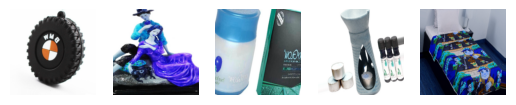

In [39]:
import matplotlib.pyplot as plt

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
)

# Générer des données augmentées
augmented_images = datagen.flow(X_train, batch_size=1)

# Extraire quelques exemples d'images augmentées
num_examples = 5
for i in range(num_examples):
    augmented_image = next(augmented_images)[0] 
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(augmented_image)
    plt.axis('off')

plt.show()

Je décide donc de tenter une autre architecture et je décide de me porter sur InceptionV3. En effet cette architecture est réputée pour son efficacité et sa précision. 

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5676 - loss: 1.4542 - val_accuracy: 0.6190 - val_loss: 3.2493
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8646 - loss: 0.6384 - val_accuracy: 0.6619 - val_loss: 2.6814
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8881 - loss: 0.5402 - val_accuracy: 0.7524 - val_loss: 1.4967
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8993 - loss: 0.5311 - val_accuracy: 0.7810 - val_loss: 1.2676
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9088 - loss: 0.4875 - val_accuracy: 0.7762 - val_loss: 1.4224
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9344 - loss: 0.4605 - val_accuracy: 0.7619 - val_loss: 1.2819
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9481 - loss: 0.3986 - val_accuracy: 0.8286 - val_loss: 0.8806
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9577 - loss: 0.3877 - val_accuracy: 0.8238 - val_loss:

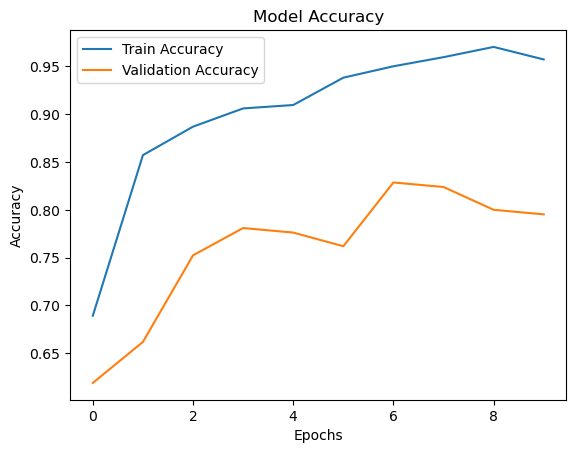

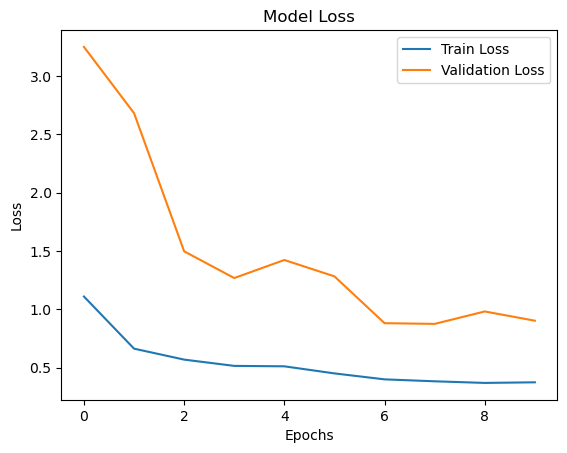

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 444ms/step - accuracy: 0.8174 - loss: 0.8123
Précision sur l'ensemble de test: 0.7952380776405334


In [43]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
)

# Utilisation de l'augmentation de données pendant l'entraînement
train_datagen = datagen.flow(X_train, y_train, batch_size=64)

# Extraction des features des images par InceptionV3
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle InceptionV3
for layer in inception_model.layers:
    layer.trainable = False

# Création du modèle avec régularisation L2 et batch normalization
model = Sequential([
    inception_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle avec l'augmentation de données
history = model.fit(
    train_datagen,
    epochs=10,
    validation_data=(X_test, y_test)
)

# Affichage de l'évolution de la précision et de la perte
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Évaluation de la performance du modèle sur l'ensemble de test
loss, accuracy = model.evaluate(X_test, y_test)
print("Précision sur l'ensemble de test:", accuracy)

Les résultats sont similaires mais il est vrai qu'en terme de temps c'est beaucoup plus rapide. 

Nous allons tout de même tester un autre modèle. 

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.5232 - loss: 2.6116 - val_accuracy: 0.4190 - val_loss: 6.0683
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7923 - loss: 1.8789 - val_accuracy: 0.6667 - val_loss: 2.6967
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8218 - loss: 1.7225 - val_accuracy: 0.7143 - val_loss: 2.3052
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8620 - loss: 1.5140 - val_accuracy: 0.7333 - val_loss: 2.0439
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9042 - loss: 1.4201 - val_accuracy: 0.7143 - val_loss: 2.1651
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8842 - loss: 1.3813 - val_accuracy: 0.7714 - val_loss: 1.9267
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8899 - loss: 1.3477 - val_accuracy: 0.7095 - val_loss: 2.0824
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.918

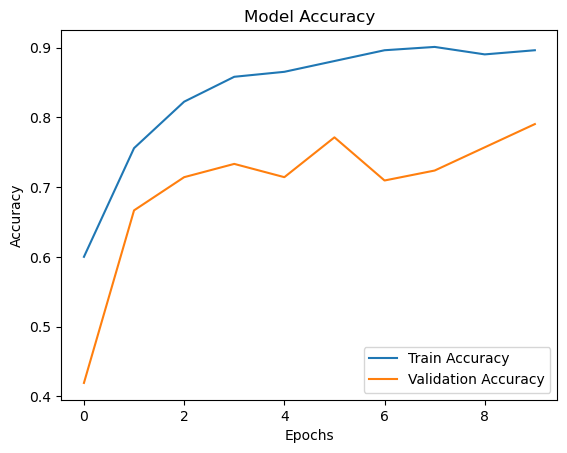

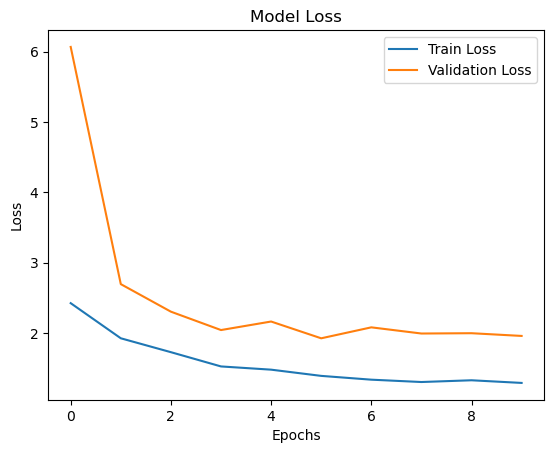

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8082 - loss: 1.8550
Précision sur l'ensemble de test: 0.7904762029647827


In [47]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
)

# Utilisation de l'augmentation de données pendant l'entraînement
train_datagen = datagen.flow(X_train, y_train, batch_size=16)

# Extraction des features des images par VGG16
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle VGG16
for layer in vgg_model.layers:
    layer.trainable = False

# Création du modèle avec régularisation L2 et batch normalization
model = Sequential([
    vgg_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle avec l'augmentation de données
history = model.fit(
    train_datagen,
    epochs=10,
    validation_data=(X_test, y_test)
)

# Affichage de l'évolution de la précision et de la perte
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Évaluation de la performance du modèle sur l'ensemble de test
loss, accuracy = model.evaluate(X_test, y_test)
print("Précision sur l'ensemble de test:", accuracy)

La précision sur l'ensemble de test est d'environ 79%, ce qui est assez bon, mais légèrement plus faible que notre modèle VGG16.

Il semblerait que pour tous ces modèles avec la data augmentation la méthode VGG16 reste pour le moment la plus pertinentes même si les résultats sont assez proches avec les autres modèles.

##### Pour conclure, nous avons pu observer que différentes méthodes peuvent s'avérer plus ou moins performantes en fonction des données utilisées.

##### Nous avons obtenu un très bon score avec les données d'origine, ce qui démontre la faisabilité de cette classification. 

##### De plus, l'application de techniques d'augmentation de données à également pu produire des résultats similaires. Ce qui nous prouve encore une fois cette faisabilité de classification avec des modèles encore plus robustes pour prévoir l'entré de nouvelles données par la suite.

##### Nous avons donc en effet pu prouver que la classification étaient bien réalisable et prometteuse pour la suite.
